<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.7 : Predicting House prices on Kaggle

In [ ]:
!pip install matplotlib_inline
!pip install --upgrade d2l==1.0.0a0

In [388]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
d2l.DATA_URL

'http://d2l-data.s3-accelerate.amazonaws.com/'

In [ ]:
class KaggleHouse(d2l.DataModule):

  def __init__(self, batch_size, train=None, val=None):
    super().__init__()
    self.save_hyperparameters()
    if self.train is None:
      self.raw_train = pd.read_csv(d2l.download(
          d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
          sha1_hash = '585e9cc93e70b39160e7921475f9bcd7d31219ce'))
      self.raw_val = pd.read_csv(d2l.download(
          d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
          sha1_hash = 'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, -3, -2, -1]])

   Id  MSSubClass MSZoning SaleType SaleCondition  SalePrice
0   1          60       RL       WD        Normal     208500
1   2          20       RL       WD        Normal     181500
2   3          60       RL       WD        Normal     223500
3   4          70       RL       WD       Abnorml     140000


In [ ]:
print(data.raw_train['MSZoning'].unique())

['RL' 'RM' 'C (all)' 'FV' 'RH']


In [ ]:
data.raw_train.dtypes[data.raw_train.dtypes != 'object'].index

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [ ]:
pd.apply??

Object `pd.apply` not found.


In [ ]:
b = data.raw_train.iloc[:4, [1, 3, 4]]
b.head()

,MSSubClass,LotFrontage,LotArea
0,60,65.0,8450
1,20,80.0,9600
2,60,68.0,11250
3,70,60.0,9550


In [ ]:
b.dtypes

MSSubClass       int64
LotFrontage    float64
LotArea          int64
dtype: object

In [ ]:
b.apply(lambda x : (x-x.mean()) / x.std())

,MSSubClass,LotFrontage,LotArea
0,0.338241,-0.382353,-1.093784
1,-1.465710,1.382353,-0.097466
2,0.338241,-0.029412,1.332034
3,0.789228,-0.970588,-0.140784


In [ ]:
pd.DataFrame.fillna??

In [ ]:
pd.get_dummies??

In [ ]:
pd.concat??

In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
  
  # " Remove the id and the label column"
  label='SalePrice'
  features = pd.concat([
      self.raw_train.drop(columns=[label, 'Id']),
      self.raw_val.drop(columns=['Id'])
  ])

  # standardize numerical columns
  numeric_features = features.dtypes[features.dtypes != 'object'].index
  features[numeric_features] = features[numeric_features].apply(lambda x : (x - x.mean()) / x.std())

  #replace 'na' values by 0
  features[numeric_features] = features[numeric_features].fillna(0)

  #hot encode the categorical data
  features = pd.get_dummies(features, dummy_na=True)

  #save pre-processed features
  self.train = features[:self.raw_train.shape[0]].copy()
  self.val = features[self.raw_train.shape[0]:].copy()

In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

In [ ]:
data.val.shape

(1459, 331)

In [ ]:
if "SalePrice" not in data.val:
  print("NO")

if "SalePrice" in data.raw_train:
  print("YES")

NO
YES


In [ ]:
def fun(a):
  if a < 0 : return
  
  a += 3
  return a - 3

In [ ]:
fun(3)
print(fun(-1))

None


In [ ]:
print(b)
print(b.values)
print(b.columns)
print(b.index)

   MSSubClass  LotFrontage  LotArea
0          60         65.0     8450
1          20         80.0     9600
2          60         68.0    11250
3          70         60.0     9550
[[   60.    65.  8450.]
 [   20.    80.  9600.]
 [   60.    68. 11250.]
 [   70.    60.  9550.]]
Index(['MSSubClass', 'LotFrontage', 'LotArea'], dtype='object')
RangeIndex(start=0, stop=4, step=1)


In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
  label = 'SalePrice'
  data = self.train if train else self.val
  if label not in data : return
  get_tensor = lambda x : torch.tensor(x.values, dtype=torch.float32)
  # log of prices
  tensors = (get_tensor(data.drop(columns=[label])), # X 
             torch.log(get_tensor(data[label])).reshape((-1, 1))) # Y
  
  return self.get_tensorloader(tensors, train)

In [ ]:
d2l.DataModule??

In [ ]:
9 // 5 #division floor

1

In [ ]:
data.batch_size

64

In [ ]:
b.drop(index = 2)

,MSSubClass,LotFrontage,LotArea
0,60,65.0,8450
1,20,80.0,9600
3,70,60.0,9550


In [ ]:
b.iloc[2]

MSSubClass        60.0
LotFrontage       68.0
LotArea        11250.0
Name: 2, dtype: float64

In [ ]:
b.loc[2]

MSSubClass        60.0
LotFrontage       68.0
LotArea        11250.0
Name: 2, dtype: float64

In [ ]:
def k_fold_data(data, k):
  rets = []
  fold_size = data.train.shape[0] // k
  for j in range(k):
    idx = range(j * fold_size, (j+1)*fold_size)
    rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))

  return rets

In [ ]:
a = d2l.LinearRegression(0.1)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
a.board.

Object `a.board.data` not found.


In [ ]:
def k_fold(trainer, data, k, lr):
  val_loss, models = [], []
  for i, data_fold in enumerate(k_fold_data(data, k)):
    model = d2l.LinearRegression(lr)
    model.board.yscale = 'log'
    if i != 0:
      model.board.display = False
    trainer.fit(model, data_fold)
    val_loss.append(float(model.board.data['val_loss'][-1].y))
    models.append(model)
    print(f"average validation log mse = {sum(val_loss)/len(val_loss)}")
    return models

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


TypeError: ignored

# dimaag kharab ho gya so trying again

In [ ]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_Credentials/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 77.8MB/s]


In [7]:
! unzip house-prices-advanced-regression-techniques.zip

Archive:  house-prices-advanced-regression-techniques.zip
  inflating: data_description.txt    
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


now we have downloaded the data

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

In [ ]:
class House():

  def __init__(self, batch_size, train=None, val=None):
    self.batch_size = batch_size
    self.train = train
    self.val = val
    if self.train is None:
      self.raw_train = pd.read_csv("train.csv")
      self.raw_val = pd.read_csv('test.csv')

In [ ]:
data = House(batch_size=64)

In [ ]:
data.raw_train.shape

(1460, 81)

In [ ]:
data.raw_val.shape

(1459, 80)

In [ ]:
data.raw_train.columns

In [ ]:
data.raw_val.columns

In [ ]:
a = data.raw_train.copy()
a.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
a.count().sum()

111295

In [ ]:
a.isnull().values.sum() / a.count().sum() * 100 # we have 6% null values

6.25814277370951

In [ ]:
label = "SalePrice"
a = a.drop(columns=[label, 'Id'])
a.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [ ]:
a = a.fillna(0)
a.isnull().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64

In [ ]:
a.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [ ]:
# let's now normalize numerical features
num_features = a.dtypes[a.dtypes != 'object'].index
num_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

In [ ]:
a[num_features] = a[num_features].apply(lambda x : (x - x.mean()) / x.std())

In [ ]:
a[num_features].mean()

MSSubClass      -9.976799e-17
LotFrontage     -2.780642e-16
LotArea         -7.056760e-17
OverallQual      1.168015e-16
OverallCond      3.309377e-16
YearBuilt        1.058514e-15
YearRemodAdd     4.484693e-15
MasVnrArea       9.787090e-18
BsmtFinSF1      -1.216683e-17
BsmtFinSF2      -1.216683e-17
BsmtUnfSF       -7.482599e-17
TotalBsmtSF      2.530700e-16
1stFlrSF         6.205082e-17
2ndFlrSF         5.170902e-17
LowQualFinSF     2.190029e-17
GrLivArea       -1.387018e-16
BsmtFullBath     1.095014e-16
BsmtHalfBath    -2.190029e-17
FullBath         1.508687e-16
HalfBath         3.650048e-17
BedroomAbvGr     2.920039e-16
KitchenAbvGr     3.577047e-16
TotRmsAbvGrd    -1.143682e-16
Fireplaces      -9.733462e-18
GarageYrBlt      4.044142e-15
GarageCars       5.353404e-17
GarageArea      -1.703356e-17
WoodDeckSF       2.920039e-17
OpenPorchSF      9.125121e-18
EnclosedPorch    8.030106e-17
3SsnPorch       -9.733462e-18
ScreenPorch     -4.258390e-18
PoolArea         4.866731e-18
MiscVal   

In [ ]:
a.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.073350,RL,-0.207948,-0.207071,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.270116,-0.068668,NaN,NaN,NaN,-0.087658,-1.598563,0.138730,WD,Normal
1,-0.872264,RL,0.409724,-0.091855,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.270116,-0.068668,NaN,NaN,NaN,-0.087658,-0.488943,-0.614228,WD,Normal
2,0.073350,RL,-0.084413,0.073455,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.270116,-0.068668,NaN,NaN,NaN,-0.087658,0.990552,0.138730,WD,Normal
3,0.309753,RL,-0.413838,-0.096864,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.270116,-0.068668,NaN,NaN,NaN,-0.087658,-1.598563,-1.367186,WD,Abnorml
4,0.073350,RL,0.574436,0.375020,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.270116,-0.068668,NaN,NaN,NaN,-0.087658,2.100173,0.138730,WD,Normal


In [ ]:
# now need to hot encode the categorical data
a = pd.get_dummies(a, dummy_na=True)
a.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.073350,-0.207948,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.509840,0.575228,-0.288554,...,0,1,0,0,0,0,0,1,0,0
1,-0.872264,0.409724,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.572637,1.171591,-0.288554,...,0,1,0,0,0,0,0,1,0,0
2,0.073350,-0.084413,0.073455,0.651256,-0.517023,0.984415,0.829930,0.322063,0.092875,-0.288554,...,0,1,0,0,0,0,0,1,0,0
3,0.309753,-0.413838,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.572637,-0.499103,-0.288554,...,0,1,0,1,0,0,0,0,0,0
4,0.073350,0.574436,0.375020,1.374324,-0.517023,0.951306,0.733056,1.360357,0.463410,-0.288554,...,0,1,0,0,0,0,0,1,0,0


now pre_processing is done : 

In [ ]:
a.shape

(1460, 331)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(a.values, data.raw_train[[label]].values, test_size=0.33, random_state=0)

In [ ]:
print(X_train_np.shape, X_test_np.shape, y_train_np.shape, y_test_np.shape)

(978, 331) (482, 331) (978, 1) (482, 1)


In [ ]:
X_train_np.dtype

dtype('float64')

In [ ]:
X_train = torch.from_numpy(X_train_np.astype(np.float32))
y_train = torch.from_numpy(y_train_np.astype(np.float32))
X_test = torch.from_numpy(X_test_np.astype(np.float32))
y_test = torch.from_numpy(y_test_np.astype(np.float32))

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([978, 331]) torch.Size([482, 331]) torch.Size([978, 1]) torch.Size([482, 1])


In [ ]:
X_train.dtype

torch.float32

In [ ]:
# hyperparameters : 

max_epochs = 100
num_inputs = X_train.shape[1]
num_outputs = y_train.shape[1]

In [ ]:
class LinearRegression(nn.Module):

  def __init__(self, num_inputs, num_outputs, lr=0.01):
    super().__init__()
    self.lr = lr
    self.lin = nn.Sequential(nn.Linear(num_inputs, num_outputs),
                             nn.ReLU())

  def forward(self, X):
    return self.lin(X)

In [ ]:
class Trainer():

  def __init__(self, max_epochs):
    self.max_epochs = max_epochs

  def fit(self, model, X, y):

    optimizer = torch.optim.SGD(model.parameters(), model.lr)
    crit = nn.MSELoss()

    # training loop : 
    for epoch in range(self.max_epochs):

      # fwd pass : y_hat and loss
      y_hat = model(X)
      loss = crit(torch.log(y_hat), torch.log(y))

      # backward pass : gradient
      loss.backward()

      # update the params
      optimizer.step()

      # zero the grad'
      optimizer.zero_grad()

      if (epoch+1) % (self.max_epochs/10) == 0:
        print(f"epoch : {epoch+1}/{self.max_epochs}, loss = {loss.item():.4f}")

In [ ]:
model = LinearRegression(num_inputs, num_outputs, lr = 0.000001)
trainer = Trainer(max_epochs)
trainer.fit(model, X_train, y_train)

epoch : 10/100, loss = nan
epoch : 20/100, loss = nan
epoch : 30/100, loss = nan
epoch : 40/100, loss = nan
epoch : 50/100, loss = nan
epoch : 60/100, loss = nan
epoch : 70/100, loss = nan
epoch : 80/100, loss = nan
epoch : 90/100, loss = nan
epoch : 100/100, loss = nan


# Trying to preprocess the data again

In [ ]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

In [105]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
from sklearn import preprocessing

In [189]:
from sklearn.model_selection import train_test_split

In [54]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

rcParams['figure.figsize'] = 16, 8
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler(color = ['#424242'])
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [90]:
df = pd.read_csv('train.csv')

In [12]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df.info()

In [15]:
df.describe??

In [22]:
profile = pp.ProfileReport(df)

In [23]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
profile.to_html()

In [25]:
profile.to_file("profle_report")

/usr/local/lib/python3.8/dist-packages/pandas_profiling/profile_report.py:314: UserWarning: Extension  not supported. For now we assume .html was intended. To remove this warning, please use .html or .json.
  warnings.warn(


Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [26]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


to hot encode : columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape']

In [52]:
df['OverallQual']

0       7
1       6
2       7
3       7
4       8
       ..
1455    6
1456    6
1457    7
1458    5
1459    5
Name: OverallQual, Length: 1460, dtype: int64

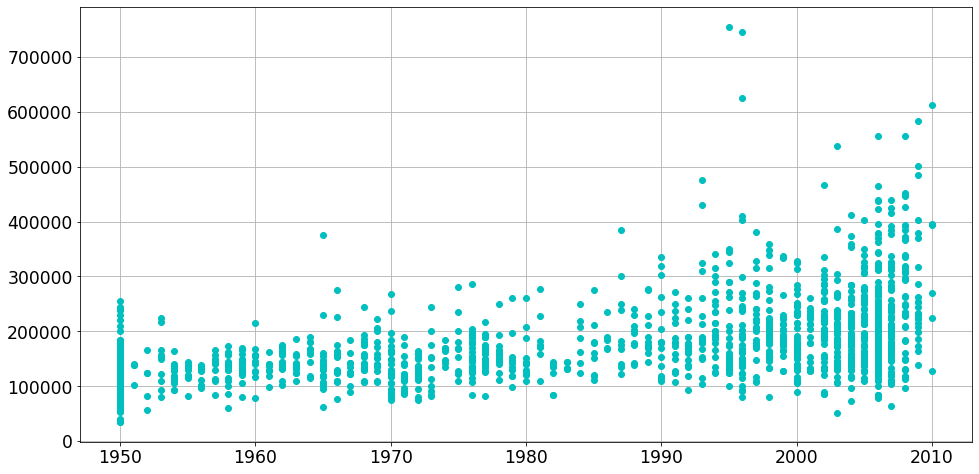

In [57]:
plt.plot(df.YearRemodAdd, df.SalePrice, 'co')
plt.grid()
plt.show();

In [62]:
df['BsmtCond']

0       TA
1       TA
2       TA
3       Gd
4       TA
        ..
1455    TA
1456    TA
1457    Gd
1458    TA
1459    TA
Name: BsmtCond, Length: 1460, dtype: object

In [65]:
df['LowQualFinSF'].astype('category')

0       0
1       0
2       0
3       0
4       0
       ..
1455    0
1456    0
1457    0
1458    0
1459    0
Name: LowQualFinSF, Length: 1460, dtype: category
Categories (24, int64): [0, 53, 80, 120, ..., 514, 515, 528, 572]

In [67]:
df['MoSold'].unique()

array([ 2,  5,  9, 12, 10,  8, 11,  4,  1,  7,  3,  6])

# Numerical Features :  
- fill null values with 0
- normalize them

# categorical features : 
- first just try hot encoding them with seperate column for null values
- then we will see about dropping the high cardinality columns

In [98]:
df['BldgType']

pandas.core.series.Series

In [94]:
len(df.dtypes[df.dtypes != object])

38

In [101]:
df.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [104]:
df.select_dtypes(exclude=['object']).columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [106]:
a = preprocessing.StandardScaler()

In [128]:
dat = [1, 2, 3, 4, np.nan]

d = pd.DataFrame(dat, columns=['Numbers'])
print(d)

   Numbers
0      1.0
1      2.0
2      3.0
3      4.0
4      NaN


In [130]:
d = d.apply(lambda x : (x - x.mean()) / x.std())

In [131]:
print(d)

    Numbers
0 -1.161895
1 -0.387298
2  0.387298
3  1.161895
4       NaN


In [123]:
d.mean()

Numbers    2.5
dtype: float64

In [124]:
d.std()

Numbers    1.290994
dtype: float64

In [119]:
a??

In [109]:
b = df.copy().select_dtypes(exclude=['object'])
b = a.fit_transform(b)

In [118]:
df.copy().select_dtypes(exclude=['object']).isnull().sum().sum()

348

In [113]:
b = pd.DataFrame(b, columns=df.copy().select_dtypes(exclude=['object']).columns)

In [117]:
b.isnull().sum().sum()

348

In [112]:
b.shape

(1460, 38)

In [135]:
dat = [['tom', 10], ['nick', 15], ['juli', 14], [np.nan, 17]]
d = pd.DataFrame(dat, columns=['Name', 'Age'])
print(d)

   Name  Age
0   tom   10
1  nick   15
2  juli   14
3   NaN   17


In [136]:
d.dtypes

Name    object
Age      int64
dtype: object

In [137]:
pd.get_dummies??

In [139]:
d_ohe = pd.get_dummies(d, dummy_na=True) # applies one hot encoding to the categorical variables only
d_ohe

,Age,Name_juli,Name_nick,Name_tom,Name_nan
0,10,0,0,1,0
1,15,0,1,0,0
2,14,1,0,0,0
3,17,0,0,0,1


In [170]:
df[df.select_dtypes(exclude=['object']).columns].fillna(0).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   OverallQual    1460 non-null   int64  
 5   OverallCond    1460 non-null   int64  
 6   YearBuilt      1460 non-null   int64  
 7   YearRemodAdd   1460 non-null   int64  
 8   MasVnrArea     1460 non-null   float64
 9   BsmtFinSF1     1460 non-null   int64  
 10  BsmtFinSF2     1460 non-null   int64  
 11  BsmtUnfSF      1460 non-null   int64  
 12  TotalBsmtSF    1460 non-null   int64  
 13  1stFlrSF       1460 non-null   int64  
 14  2ndFlrSF       1460 non-null   int64  
 15  LowQualFinSF   1460 non-null   int64  
 16  GrLivArea      1460 non-null   int64  
 17  BsmtFullBath   1460 non-null   int64  
 18  BsmtHalf

In [367]:
def pre_process(df):

  # drop the 'Id' column
  # df.drop(['Id', 'SalePrice'], axis=1, inplace=True)

  # get the numerical features
  numerical_features = df.select_dtypes(exclude=['object']).columns

  # now scale with mean = 0 and var = 1
  df[numerical_features] = df[numerical_features].apply(lambda x : (x - x.mean()) / x.std())

  # fill null values with 0
  df[numerical_features] = df[numerical_features].fillna(0)

  # one hot encode the categorical columns
  # df = pd.get_dummies(df, dummy_na=True)


In [346]:
raw_train = pd.read_csv('train.csv')

In [187]:
df[['SalePrice']].shape

(1460, 1)

In [368]:
abt = raw_train.copy()
pre_process(abt)

In [369]:
ids = abt['Id']
X = abt.drop(columns=['Id', "SalePrice"], axis=1)
X = pd.get_dummies(X)
y = abt[['SalePrice']]

In [370]:
type(X.values)

numpy.ndarray

In [371]:
print(X.shape, y.shape)

(1460, 288) (1460, 1)


In [373]:
print(X.mean())

MSSubClass              -1.216683e-17
LotFrontage              1.825024e-17
LotArea                 -4.866731e-18
OverallQual             -9.733462e-18
OverallCond             -1.216683e-18
                             ...     
SaleCondition_AdjLand    2.739726e-03
SaleCondition_Alloca     8.219178e-03
SaleCondition_Family     1.369863e-02
SaleCondition_Normal     8.205479e-01
SaleCondition_Partial    8.561644e-02
Length: 288, dtype: float64


In [372]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=0)

In [195]:
import torch
from torch import nn

In [375]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [376]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([1022, 288]) torch.Size([1022, 1])
torch.Size([438, 288]) torch.Size([438, 1])


In [377]:
# we are working with the log of the Sale Prices
y_train = torch.log(y_train)
y_test = torch.log(y_test)

- now we have the dataset : let's start making the model

In [206]:
X_train.dtype

torch.float32

## 1st model : simple liner regression model : 

In [378]:
class LinearRegression(nn.Module):

  def __init__(self, num_inputs, num_outputs, lr):
    super().__init__()
    self.lr = lr
    self.lin = nn.Linear(num_inputs, num_outputs)

  def forward(self, X):
    return self.lin(X)

In [379]:
# hyper-parameters
hparams = {
    'num_inputs': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'lr': 0.1
}

In [380]:
model = LinearRegression(**hparams)
optimizer = torch.optim.SGD(model.parameters(), model.lr)
crit = nn.MSELoss()

In [381]:
# training loop : 
max_epochs = 100

for epoch in range(max_epochs):

  # fwd pass : y_hat and loss
  y_hat = model.forward(X_train)
  loss = torch.sqrt(crit(y_hat, y_train))

  # backward pass : gradient
  loss.backward()

  # update the params
  optimizer.step()

  # zero the grad
  optimizer.zero_grad()

  if (epoch+1) % (max_epochs/10) == 0:
    print(f"epoch : {epoch+1}/{max_epochs}, loss = {loss.item():.4f}")

epoch : 10/100, loss = nan
epoch : 20/100, loss = nan
epoch : 30/100, loss = nan
epoch : 40/100, loss = nan
epoch : 50/100, loss = nan
epoch : 60/100, loss = nan
epoch : 70/100, loss = nan
epoch : 80/100, loss = nan
epoch : 90/100, loss = nan
epoch : 100/100, loss = nan


In [382]:
# evalutation : 
with torch.no_grad():
  y_hat = model.forward(X_test)
  loss = torch.sqrt(crit(y_hat, y_test))
  print(f"loss = {loss.item():.4f}")

loss = nan


## Let's try with 2 hidden layers and dropout : 

In [383]:
class MLP(nn.Module):

  def __init__(self, num_inputs, num_outputs, num_hiddens_1, num_hiddens_2, dropout_1, dropout_2, lr):
    super().__init__()
    self.lr = lr
    self.net = nn.Sequential(nn.Linear(num_inputs, num_hiddens_1),
                             nn.ReLU(),
                             nn.Dropout(dropout_1),
                             nn.Linear(num_hiddens_1, num_hiddens_2),
                             nn.ReLU(),
                             nn.Dropout(dropout_2),
                             nn.Linear(num_hiddens_2, num_outputs))
    
  def forward(self, X):
    return self.net(X)

In [384]:
hparams = {
    'num_inputs': X_train.shape[1],
    'num_outputs': y_train.shape[1],
    'num_hiddens_1': 128,
    'num_hiddens_2': 256,
    'dropout_1': 0.3,
    'dropout_2': 0.7,
    'lr': 0.6
}

In [385]:
model = MLP(**hparams)
optimizer = torch.optim.SGD(model.parameters(), model.lr)
criterion = nn.MSELoss()

In [386]:
# training loop : 
max_epochs = 100

for epoch in range(max_epochs):

  # fwd pass : y_hat and loss
  y_hat = model.forward(X_train)
  loss = torch.sqrt(crit(y_hat, y_train))

  # backward pass : gradient
  loss.backward()

  # update the params
  optimizer.step()

  # zero the grad
  optimizer.zero_grad()

  if (epoch+1) % (max_epochs/10) == 0:
    print(f"epoch : {epoch+1}/{max_epochs}, loss = {loss.item():.4f}")

epoch : 10/100, loss = nan
epoch : 20/100, loss = nan
epoch : 30/100, loss = nan
epoch : 40/100, loss = nan
epoch : 50/100, loss = nan
epoch : 60/100, loss = nan
epoch : 70/100, loss = nan
epoch : 80/100, loss = nan
epoch : 90/100, loss = nan
epoch : 100/100, loss = nan


In [324]:
# evalutation : 
with torch.no_grad():
  y_hat = model.forward(X_test)
  loss = torch.sqrt(crit(y_hat, y_test))
  print(f"loss = {loss.item():.4f}")

loss = 0.3972


Let's make 1st submission

In [338]:
df = pd.read_csv('test.csv')

In [336]:
df.isnull().sum().sum()

6670

In [339]:
df['SalePrice'] = 0
id = df[['Id']].values
X = pre_process(df).values

In [340]:
X.shape

(1459, 313)

In [332]:
X = torch.from_numpy(X.astype(np.float32))

RuntimeError: ignored

## Fuck...ye bhi nhi hua

In [389]:
class KaggleHouse(d2l.DataModule):

  def __init__(self, batch_size, train=None, val=None):
    super().__init__()
    self.save_hyperparameters()
    if self.train is None:
      self.raw_train = pd.read_csv('train.csv')
      self.raw_val = pd.read_csv('test.csv')

In [390]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


In [391]:
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

In [394]:
dat_a = [['a', 1], ['b', 2], ['c', 3]]
a = pd.DataFrame(dat_a, columns=['Name', "Value"])

dat_b = [['d', 4], ['e', 5], ['f', 6]]
b = pd.DataFrame(dat_b, columns=['Name', 'Value'])

c = pd.concat([a, b])
print(c)

  Name  Value
0    a      1
1    b      2
2    c      3
0    d      4
1    e      5
2    f      6


In [395]:
a[:a.shape[0]]

,Name,Value
0,a,1
1,b,2
2,c,3


In [396]:
c[a.shape[0]:]

,Name,Value
0,d,4
1,e,5
2,f,6


In [399]:
@add_to_class(KaggleHouse)
def preprocess(self):
  # remove the label and id columns
  
  label = "SalePrice"
  features = pd.concat([
      self.raw_train.drop(columns=['Id', label]),
      self.raw_val.drop(columns=['Id'])
  ])

  # standarize numerical features
  numeric_features = features.select_dtypes(exclude=['object']).columns
  features[numeric_features] = features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
  features[numeric_features] = features[numeric_features].fillna(0)

  # one hot encode the categorical columns
  features = pd.get_dummies(features, dummy_na=True)

  # save pre-processed features
  self.train = features[:self.raw_train.shape[0]].copy()
  self.train[label] = self.raw_train[label]
  self.val = features[self.raw_train.shape[0]:].copy()

In [400]:
data.preprocess()
print(data.train.shape, data.val.shape)

(1460, 332) (1459, 331)


In [401]:
d2l.DataModule??

In [402]:
torch.utils.data.TensorDataset??

In [403]:
from scipy.special import gammaincc
@add_to_class(KaggleHouse)
def get_dataloader(self, train):
  label = 'SalePrice'
  data = self.train if train else self.val
  if label not in data: return
  get_tensor = lambda x : torch.tensor(x.values, dtype=torch.float32)

  # log of prices
  tensors = (get_tensor(data.drop(columns=[label])), # (X, y)
             torch.log(get_tensor(data[[label]])))
  
  return self.get_tensorloader(tensors, train)

In [404]:
def k_fold_data(data, k):
  rets = []
  fold_size = data.train.shape[0] // k
  for j in range(k):
    idx = range(j * fold_size, (j+1) * fold_size)
    rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx), data.train.loc[idx]))
  return rets

In [405]:
def k_fold(trainer, data, k, lr):
  val_loss, models = [], []
  for i, data_fold in enumerate(k_fold_data(data, k)):
    model = d2l.LinearRegression(lr)
    model.board.yscale='log'
    if i != 0:
      model.board.display=False

    trainer.fit(model, data_fold)
    val_loss.append(float(model.board.data['val_loss'][-1].y))
    models.append(model)
    print(f"average validation log mse = {sum(val_loss)/len(val_loss)}")
    return models

average validation log mse = 0.1612772285938263


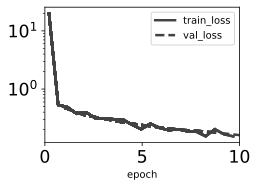

In [406]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

In [417]:
torch.cat??

In [410]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32)) for model in models]

ensemble_preds = torch.exp(torch.cat(preds, 1)).mean()
submission = pd.DataFrame({'Id' : data.raw_val.Id,
                           'SalePrice' : ensemble_preds.detach().numpy()})

submission.to_csv("submission.csv", index=False)

In [416]:
print(preds)
print(torch.cat(preds, 1))

[tensor([[11.2516],
        [13.1013],
        [12.1790],
        ...,
        [12.4727],
        [11.4792],
        [12.2222]], grad_fn=<AddmmBackward0>)]
tensor([[11.2516],
        [13.1013],
        [12.1790],
        ...,
        [12.4727],
        [11.4792],
        [12.2222]], grad_fn=<CatBackward0>)
